In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using FastExpm
using StaticArrays
using Optimization
using DiffEqFlux
# using DiffEqFlux: sciml_train
using Optim

In [185]:
f'([10])[1]

0.0

In [210]:
function f(x)
    (x[1]-10)^2
end

function g!(storage, x)
    storage[1] = gradient(f,x)[1][1]
end

g! (generic function with 1 method)

In [211]:
solution = optimize(f,g!,[0.0],method=LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.00e+01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.00e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [180]:
Optim.minimizer(solution)

1-element Vector{Float64}:
 10.000000000118629

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N)))
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

In [3]:
#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi;

In [4]:
prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Potential3 = -2pi * E_J_GHz * E_J / 2 * (exp(im * phi_ext) * kron(exp_iPhi, exp_iPhi') .+ exp(-im * phi_ext) * kron(exp_iPhi', exp_iPhi)) #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 .+ Potential2)
KinPot12 = Kinetic .+ Potential12
chargecoupling = kron(n, Id);

In [53]:
qubit_freq = 2.4825403959499113
level = 0.7
decline_end = 10
ascend_start = 20
function alpha(u, p, t)
    if t < decline_end
        return 1 - (1 - level) / decline_end * t
    elseif t > ascend_start
        return level + (1 - level) / decline_end * (t - ascend_start)
    else
        return level
    end
end

Tpulse = 10.0
phase_offset = 0.0pi
freq_scale = 1.0 - 0.022 + 0.001#- 1e-1*(-0.0027936870890755317)
tspan = (0.0, Tpulse)
t_ramp = 2.0
function pulse(u, p, t)
    area = tspan[2] - t_ramp
    if 0 < t < t_ramp
        amp = sin(pi / 2 * t / t_ramp)^2
    elseif t_ramp <= t <= tspan[2] - t_ramp
        amp = 1
    elseif tspan[2] - t_ramp < t < tspan[2]
        amp = sin(pi / 2 * (tspan[2] - t) / t_ramp)^2
    else
        amp = 0
    end
    amp *= 1.3314045280692275
    return amp * cos(p[1] * qubit_freq * t + phase_offset)
end

function H_int(u, p, t)
    H = KinPot12 + alpha(u, p, t) * Potential3
    V = pulse(u, p, t - 10) * chargecoupling
    return - im * (H + V) * u
end

function H_int!(du, u, p, t)
    H = KinPot12 + alpha(u, p, t) * Potential3
    V = pulse(u, p, t - 10) * chargecoupling
    du[:] = - im * (H + V) * u
    return nothing
end

H_int! (generic function with 1 method)

In [54]:
Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, ncv = 100,maxiter=1000);

In [55]:
p = @SVector [freq_scale]
prob1 = ODEProblem(H_int!, ψs[:,1], (0.0, 30), Array(p))

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: 289-element Vector{ComplexF64}:
 -2.3180266042096687e-10 - 7.08907852925527e-10im
   -3.767907594418055e-9 - 3.765617037112696e-9im
  -2.9447505742743694e-8 - 8.549813505161498e-9im
  -1.3503738541329526e-7 + 5.3076860127384935e-8im
  -2.2747301386024138e-7 + 5.498319860046997e-7im
    9.890680833138356e-7 + 1.819239946982691e-6im
    5.735572417336693e-6 + 2.4851550033384595e-7im
    5.587191766983632e-6 - 1.2744698908599228e-5im
   -2.070324111669605e-5 - 1.862007552328681e-5im
   -3.360549092674305e-5 + 2.800333384850539e-5im
                         ⋮
     5.70291971473099e-6 - 2.725450626882693e-5im
  -1.2037437860168333e-5 - 6.98170121639265e-6im
  -4.4807287579039605e-6 + 3.5890974779399323e-6im
   2.7681562435969314e-7 + 2.0521361476367466e-6im
    5.083710708889456e-7 + 3.0922166664368757e-7im
   1.4030828885577663e-7 - 3.695717280857349e-8im
   1.8707470602790915e-8 - 2.429579

In [56]:
sol = solve(prob1, p=p, saveat=30.0, reltol=1e-12, abstol=1e-15)#.+ - 0.00025

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 30.0
u: 2-element Vector{Vector{ComplexF64}}:
 [-2.3180266042096687e-10 - 7.08907852925527e-10im, -3.767907594418055e-9 - 3.765617037112696e-9im, -2.9447505742743694e-8 - 8.549813505161498e-9im, -1.3503738541329526e-7 + 5.3076860127384935e-8im, -2.2747301386024138e-7 + 5.498319860046997e-7im, 9.890680833138356e-7 + 1.819239946982691e-6im, 5.735572417336693e-6 + 2.4851550033384595e-7im, 5.587191766983632e-6 - 1.2744698908599228e-5im, -2.070324111669605e-5 - 1.862007552328681e-5im, -3.360549092674305e-5 + 2.800333384850539e-5im  …  4.365789504257991e-5 + 2.7393297557775816e-6im, 5.70291971473099e-6 - 2.725450626882693e-5im, -1.2037437860168333e-5 - 6.98170121639265e-6im, -4.4807287579039605e-6 + 3.5890974779399323e-6im, 2.7681562435969314e-7 + 2.0521361476367466e-6im, 5.083710708889456e-7 + 3.0922166664368757e-7im, 1.4030828885577663e-7 - 3.695717280857349e-8im, 1.8707470602790915e-8 - 2.429579084529217

In [10]:
abs2.(ψs'*sol.u[end])

2-element Vector{Float64}:
 6.0376617099799245e-5
 0.9998335403336751

In [105]:
NHilbert = 289#Int(N^2)
ψT = sol.u[end]
a = - dropdims(ψT'*ψs[:,2]*ψs[:,2]',dims=1)
u0_aug = cat(a,ψT,zeros(Float64,1),dims=1);

function dpulsedp(u, p, t)
    area = tspan[2] - t_ramp
    if 0 < t < t_ramp
        amp = sin(pi / 2 * t / t_ramp)^2
    elseif t_ramp <= t <= tspan[2] - t_ramp
        amp = 1
    elseif tspan[2] - t_ramp < t < tspan[2]
        amp = sin(pi / 2 * (tspan[2] - t) / t_ramp)^2
    else
        amp = 0
    end
    amp *= 1.3314045280692275
    return - amp * qubit_freq * t * sin(p[1] * qubit_freq * t + phase_offset)
end

function augmented_H_int!(du, u, p, t)
    H = KinPot12 + alpha(u, p, t) * Potential3
    V = chargecoupling
    hamil = H + pulse(u, p, t - 10) .* V
    du[1:NHilbert] = im .* reshape(u[1:NHilbert],(1,:)) * hamil
    du[NHilbert+1:end-1] = -im .* hamil *u[NHilbert+1:end-1]
    # tmp = (- im .* V * u[NHilbert+1:end-1])#*dpulsedp(u, p, t)
    du[end] = 2*real(- reshape(u[1:NHilbert],(1,:))*(- im .* V * u[NHilbert+1:end-1])*dpulsedp(u, p, t - 10))[1]
    # du[:] = - im * (H + V) * u
    return nothing
end


augmented_H_int! (generic function with 1 method)

In [106]:
aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), Array(p));

In [107]:
aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-12, abstol=1e-15)# .+ - 0.00025

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 30.0
  0.0
u: 2-element Vector{Vector{ComplexF64}}:
 [-6.237121843236395e-10 - 3.52609649906204e-10im, -5.158719361160956e-9 - 1.1141377073881846e-10im, -2.729100462501387e-8 + 1.4074298397843107e-8im, -6.88067209666249e-8 + 1.2999333302568814e-7im, 1.584514290888388e-7 + 5.416120946719743e-7im, 1.7887560178059838e-6 + 5.823492381046617e-7im, 4.202233615628126e-6 - 3.8047279014664937e-6im, -3.874162423452538e-6 - 1.2522534694969524e-5im, -2.5800339394885335e-5 + 2.444862489239385e-6im, -4.922989087669862e-6 + 4.2947461934480014e-5im  …  1.1551170188077898e-5 - 2.326255227587329e-5im, 1.3050124021055473e-5 + 2.931421015450636e-6im, 1.071920541044616e-6 + 5.500714802443114e-6im, -1.4864005799745874e-6 + 1.271974948271611e-6im, -5.6410210840428e-7 - 1.2072383626934274e-7im, -7.675984009718504e-8 - 1.2206995177271535e-7im, 2.678160979275436e-9 - 3.085650624685216e-8im, 2.997568069426492e-9 - 4.639627621934904e-

In [ ]:
aug_occs = zeros(Float64,length(aug_sol.t),2)
@time for i = 1:length(aug_sol.t)
    if (aug_sol.t[i] >= 10) & (aug_sol.t[i] <= 20)
        aug_occs[i,:] = abs2.(ψs07'*aug_sol.u[i][NHilbert+1:end-1])
    end
end
# aug_sol.u[:][NHilbert+1:end-1]

In [108]:
aug_sol.u[end][end] #at δp = +0.001

0.0641479379175103 + 0.0im

In [52]:
aug_sol.u[end][end] #at δp = -0.001
#-0.03199025827714187 + 0.0im

-0.040740507652518056 + 12.543780178044315im

In [ ]:
aug_sol.u[end][end] #at δp = +0.0005

In [ ]:
aug_sol.u[end][end] #at δp = -0.0005

In [44]:
aug_sol.u[end][end] #at δp = 0
# 0.83719283 + 22im

-0.004387670681111667 + 12.535623322375267im

In [36]:
-0.008775341362248449/2, -0.008775352355883115

-0.0043876706811242245

In [ ]:
log10.(aug_occs[3941-27:2*(3941-27)+5,1])#, ψs[:,1]'*aug_sol.u[end][NHilbert+1:end-1]

In [109]:
ps = LinRange(0.001 - 10^-5,0.001+10^-5,3)
out = zeros(Float64,length(ps))
@time for i = 1:length(ps)
    out[i] = loss(p[1] - 0.001 .+ ps[i])
end

 15.794088 seconds (9.25 M allocations: 23.161 GiB, 17.98% gc time)


0.06414790811315446

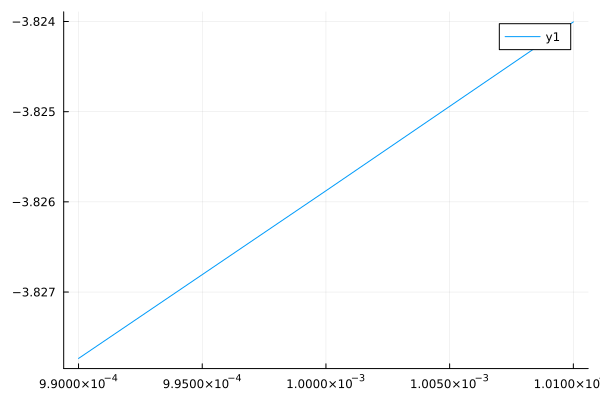

In [110]:
print((out[3] - out[1])/(2*(ps[2]-ps[1])))
plot(ps,log10.(out))

In [77]:
(out[3] - out[1])/(2*(ps[2]-ps[1])), (out[3] - out[2])/((ps[3]-ps[2]))


(0.13728600558038337, 0.13765222932615692)

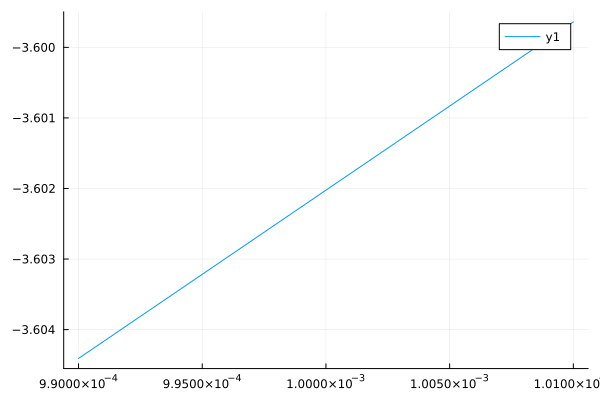

In [67]:
plot(ps,log10.(out))

Check EnvelopedPulse_ManualAdj for the results i suppose...

In [61]:
function loss(p)
    sol = solve(prob1, p=p, saveat=30.0, reltol=1e-8, abstol=1e-8, sensealg=BacksolveAdjoint())
    return 1 - abs2(ψs[:,2]'*sol.u[end])
end

loss (generic function with 1 method)

In [11]:
loss(p)
# optprob = Optimization.OptimizationProblem(loss, Array(p))

0.00016680162591109493

In [18]:
gradient(loss, p)
# res = Optimization.solve(optprob, ADAM(1e-2),maxiters=100)

In [ ]:
res = sciml_train(loss, p, BFGS(initial_stepnorm=1e-6))

In [ ]:
@time sol1 = solve(prob1, reltol=1e-12, abstol=1e-15,saveat=30.0)

In [ ]:
prob2 = ODEProblem(H_int, ψs[:,2], (0.0, 30))
@time sol2 = solve(prob2, reltol=1e-12, abstol=1e-15, save_everystep=false)

In [ ]:
Es07, ψs07 = eigs(KinPot12 + 0.7 .* Potential3, nev=2, which=:SR, ncv = 100,maxiter=1000);

In [ ]:
occs = zeros(Float64, 200, 2)
@time for i = 1:200
    occs[i,:] = abs2.(ψs07'*sol1.u[i])
end

In [ ]:
occs2 = zeros(Float64, 200, 2)
@time for i = 1:200
    occs2[i,:] = abs2.(ψs07'*sol1.u[i])
end

In [ ]:
sol1.u[1]'*sol1.u[1]

In [ ]:
occs[50,:]

In [ ]:
plot(sol1.t, [log10.(occs), log10.(occs2)])

In [ ]:
abs2.(ψs'*sol1.u[end]), abs2.(ψs'*sol2.u[end])